## See pd_control.py - define dynamics section

In [1]:
import control

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

# Ogata
# def get_ss_A(m1, m2, l, g=-9.807):
#     return [
#         [0, 1, 0, 0],
#         [0, 0, m2 * g /m1, 0],
#         [0, 0, 0, 1],
#         [0, 0, -(m1 + m2) * g / (m1*l), 0]
#     ]

# def get_ss_B(m1, l):
#     return [0, 1/m1, 0, 1/(m1 * l)]

# Steve Brunton
def get_ss_A(m1, m2, l, d=1, pendulum_up=True, g=-9.807):
    b = 1 if pendulum_up else -1
    return [
        [0, 1, 0, 0],
        [0, -d/m1, b*m2*g/m1, 0],
        [0, 0, 0, 1],
        [0, -b*d/(m1*l), -b*(m1+m2)*g/(m1*l), 0]
    ]

def get_ss_B(m1, l, pendulum_up=True):
    b = 1 if pendulum_up else -1
    return [0, 1/m1, 0, b/(m1 * l)]

m1 = 2
m2 = 1
l = 85.4/2 * 0.01 # (?)

A = np.array(get_ss_A(m1, m2, l))
B = np.array(get_ss_B(m1, l)).reshape(4, 1)
C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

model_plant = control.ss(A, B, C, 0)

In [2]:
model_plant.issiso()

False

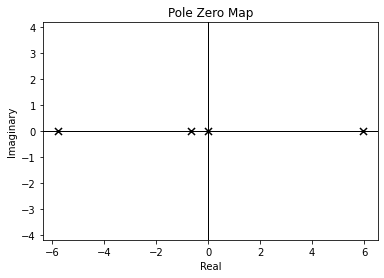

In [3]:
poles, zeros = control.pzmap(model_plant)
plt.show()

In [4]:
poles, zeros

(array([ 0.        , -5.77603142, -0.66885945,  5.94489087]),
 array([], dtype=float64))

## LQR design

In [5]:
if A.shape[0] == np.linalg.matrix_rank(control.ctrb(A, B)):
    print("System is controllable.")
else:
    print("System is not fully controllable.")

System is controllable.


In [6]:
Q = np.zeros((4, 4))
# np.fill_diagonal(Q, [1e-2, 1e-2, 1e6, 1e5]) 
np.fill_diagonal(Q, [1, 1, 1, 1]) # theta_dot > theta 
R = 100

K_lqr, _, poles = control.lqr(model_plant, Q, R)

### Verify

[-5.96348914 -5.75785039 -0.10064562 -0.66458819]


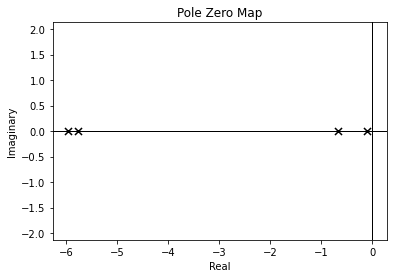

In [7]:
model_cl = control.ss(A-B@K_lqr, B, C, 0)
poles, zeros = control.pzmap(model_cl)
print(poles)
plt.show()

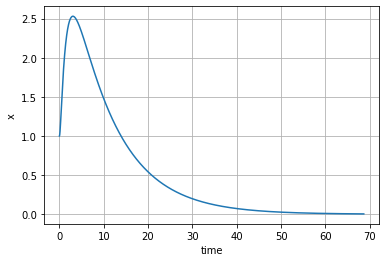

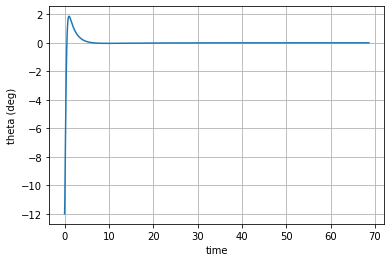

In [8]:
x0 = [1, 0, -12 * np.pi/180, 0]

T, y_out = control.initial_response(model_cl, X0=x0)

plt.plot(T, y_out[0])
plt.xlabel("time")
plt.ylabel("x")
plt.grid()
plt.show()

plt.plot(T, y_out[1] * 180/np.pi)
plt.xlabel("time")
plt.ylabel("theta (deg)")
plt.grid()
plt.show()

# plt.plot(T, y_out * 180/np.pi)
# plt.xlabel("time")
# plt.ylabel("theta (deg)")
# plt.grid()
# plt.show()

### Solve system explicitly - solve_ivp

In [9]:
model_cl

StateSpace(array([[  0.        ,   1.        ,   0.        ,   0.        ],
       [  0.05      ,   0.58909533, -38.15576254,  -5.58331052],
       [  0.        ,   0.        ,   0.        ,   1.        ],
       [  0.11709602,   1.37961435, -43.42333147, -13.07566867]]), array([[0.        ],
       [0.5       ],
       [0.        ],
       [1.17096019]]), array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]]), array([[0.],
       [0.]]))

In [10]:
K_lqr

array([[-0.1       , -2.17819066, 66.50452508, 11.16662104]])

In [11]:
A_cl = A - B @ K_lqr
A_cl

array([[  0.        ,   1.        ,   0.        ,   0.        ],
       [  0.05      ,   0.58909533, -38.15576254,  -5.58331052],
       [  0.        ,   0.        ,   0.        ,   1.        ],
       [  0.11709602,   1.37961435, -43.42333147, -13.07566867]])

In [12]:
def system_cl(t, x):
#     return A_cl @ x
    return A @ x + (B * (np.zeros((4, 1)) - K_lqr @ x)).reshape(-1)

In [13]:
soln = integrate.solve_ivp(system_cl, [0, 11], x0)

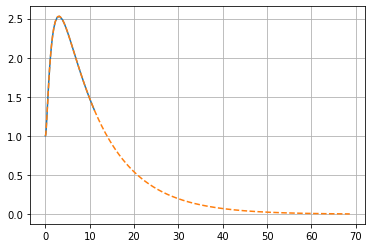

In [14]:
plt.plot(soln.t, soln.y[0])
plt.plot(T, y_out[0], '--')
plt.grid('on')

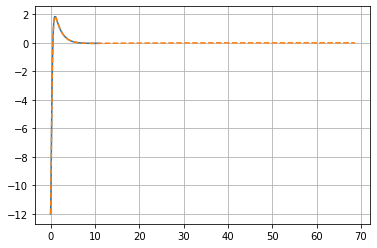

In [15]:
# plt.plot(soln.t, soln.y[0])
plt.plot(soln.t, soln.y[2] * 180/np.pi)
plt.plot(T, y_out[1] * 180/np.pi, '--')
plt.grid('on')

Text(0, 0.5, 'force on cart [N]')

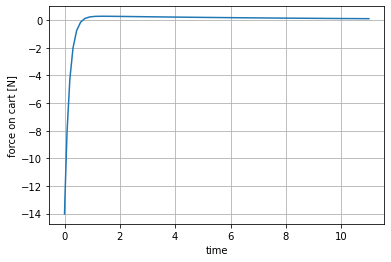

In [16]:
plt.plot(soln.t, (K_lqr@soln.y).reshape(-1))
plt.grid('on')
plt.xlabel('time')
plt.ylabel('force on cart [N]')

#### NOTE: In pybullet we apply torque, not force. 

Find the diameter of the wheels;

T = F * d

or equivalently,

u_nom = F * d 

d = 39/2m * scale
  
  = 39/2m * 0.01
  
Ultimately,

u_nom = F * 0.195

Text(0, 0.5, 'control input - motor torque [Nm]')

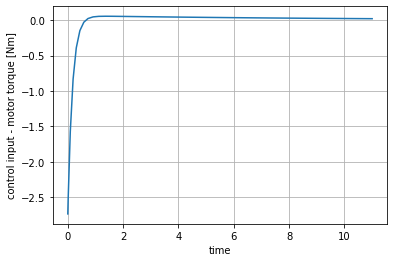

In [17]:
plt.plot(soln.t, (K_lqr@soln.y).reshape(-1) * 0.195)
plt.grid('on')
plt.xlabel('time')
plt.ylabel('control input - motor torque [Nm]')